In [3]:
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import collections
import cv2
import numpy as np

def get_all_bounding_box_from_file(path):
    """
    return: list of pair (bounding_box, label)
    """
    root = ET.parse(path).getroot()
    res = []
    for member in root.findall('object'):
        label = member.find('name').text
        box = member.find('bndbox')
        bounding_box = [int(box[i].text) for i in range(4)]
        res.append((bounding_box, label))
    return res

In [4]:
label_path = '../data/labels/'
all_label_files = [label_path+x for x in os.listdir(label_path)]
get_all_bounding_box_from_file(all_label_files[0])

[([61, 179, 209, 295], 'power_supply'),
 ([304, 301, 352, 332], 'regulation'),
 ([392, 59, 448, 92], 'capacitance'),
 ([579, 109, 625, 130], 'LED'),
 ([483, 269, 655, 298], 'resistance'),
 ([708, 344, 763, 377], 'capacitance')]

In [5]:
def in_box(bounding_box, pos):
    """
    return: whether the position is inside the bounding box
    """
    return bounding_box[0] <= pos[0] <= bounding_box[2] and bounding_box[1] <= pos[1] <= bounding_box[3]


In [6]:
def get_all_connected_pixels(img, start_pos):
    """
    Two pixels are called connected if there is a sequence of intermediate pixels that are exactly the same and are adjacent to each other
    return: all pixels connected to the start_pos.
    """
    
    queue = collections.deque()
    visited = set()
    pixel = img[start_pos[0]][start_pos[1]]
    queue.append(start_pos)
    visited.add(start_pos)
    
    while queue:
        pos = queue.popleft()
        for i, j in [[pos[0]-1, pos[1]], [pos[0], pos[1]-1], [pos[0]+1, pos[1]], [pos[0], pos[1]+1]]:
            if 0 <= i < len(img) and 0 <= j < len(img[0]) and (i, j) not in visited and img[i][j] == pixel:
                queue.append((i, j))
                visited.add((i, j))
    return visited


def display_by_marking(img, target_ixs, color=(255, 0, 0)):
    """
    Display the image after marking pixels as ixs to the target color
    """
    img = np.array(img)
    for i, j in target_ixs:
        img[i, j] = color
    plt.figure()
    plt.imshow(img, cmap='gray')

In [7]:
processed_path = '../data/processed_data/'
all_top_files = [processed_path+x for x in os.listdir(processed_path) if 'top' in x and 'copper' not in x]
all_top_copper_files = [processed_path+x for x in os.listdir(processed_path) if 'top' in x and 'copper' in x]

In [8]:
def get_binary_copper_img(path):
    img = cv2.imread(path)
    return np.array(img[:, :, 0] > 0.5).astype('int')

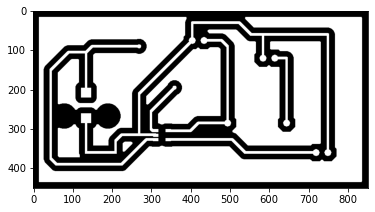

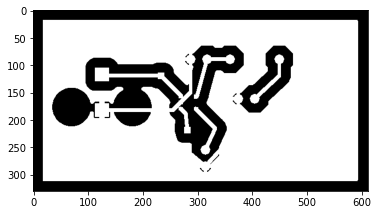

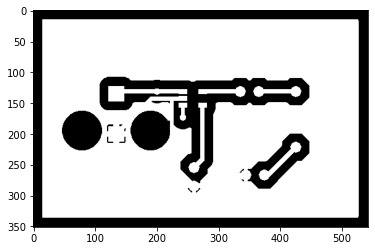

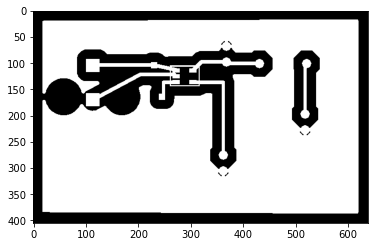

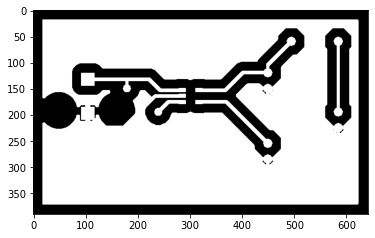

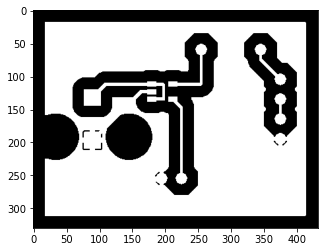

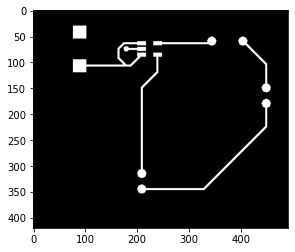

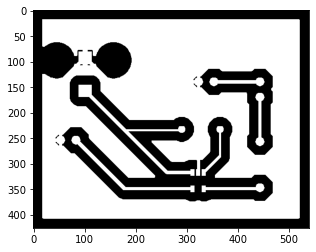

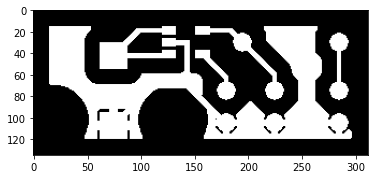

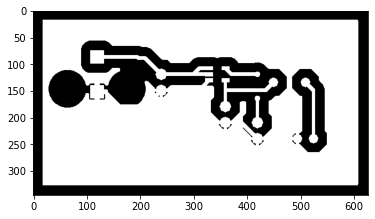

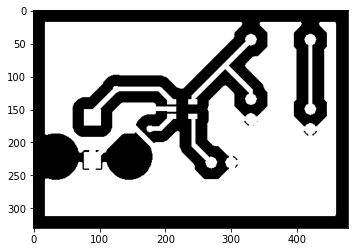

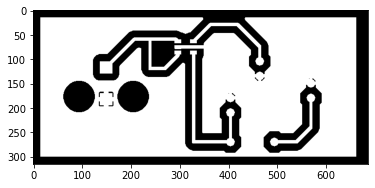

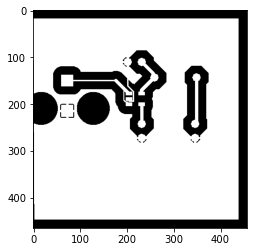

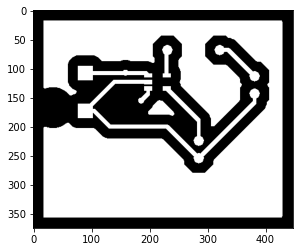

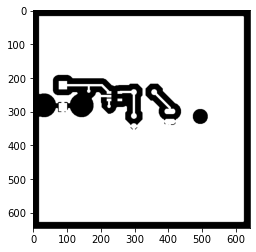

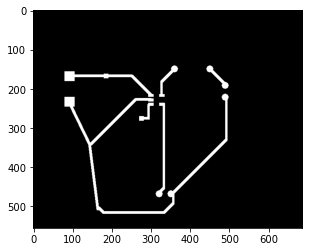

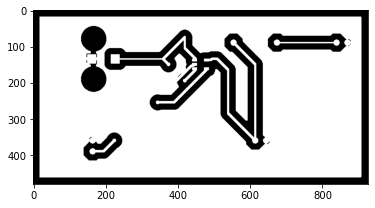

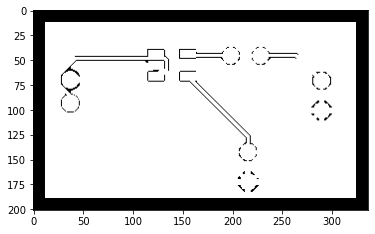

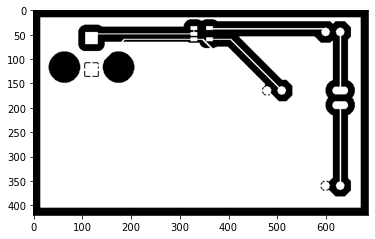

In [9]:
for i in range(len(all_top_copper_files)):
    plt.figure()
    plt.imshow(get_binary_copper_img(all_top_copper_files[i]), cmap='gray')

In [10]:
def display_all_white_regions(img):
    visited = set()
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] == 1 and (i, j) not in visited:
                all_connected = get_all_connected_pixels(img, (i, j))
                display_by_marking(img, all_connected, color=2)
                visited = visited.union(all_connected)


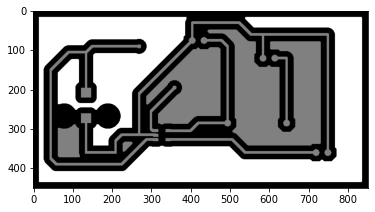

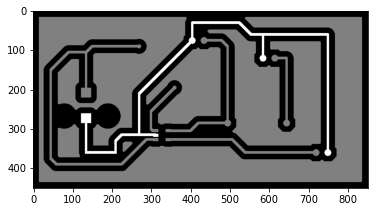

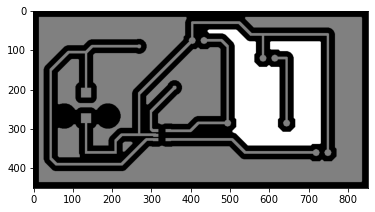

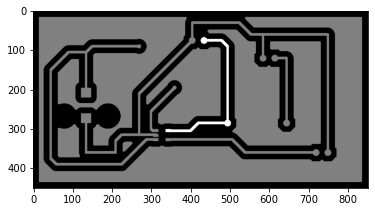

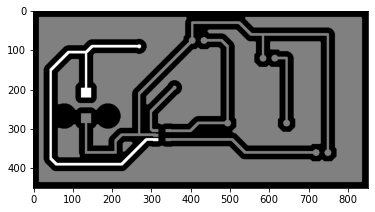

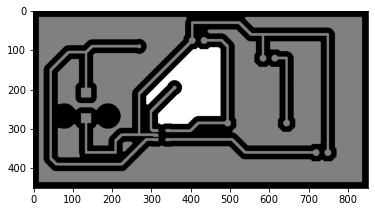

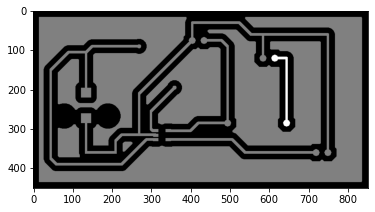

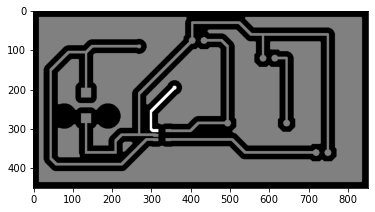

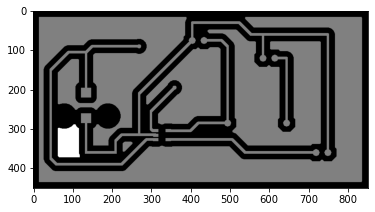

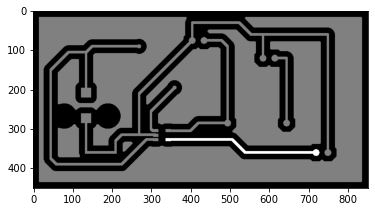

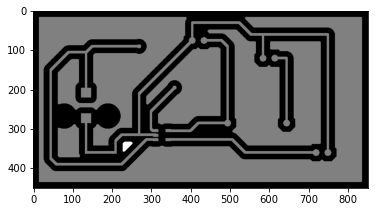

In [11]:
display_all_white_regions(get_binary_copper_img(all_top_copper_files[0]))